# Exploratory Data Analysis
- enforce datatypes
- engineer new variables
- encode categorical features
- imputing missing values
- Statistical tests    
    
### Resources
- http://www.biostathandbook.com/testchoice.html

In [1]:
import datetime
import sys
import os
import json
import re
import pickle
import traceback
import warnings
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sqlalchemy import create_engine
from sqlalchemy.sql import text
from importlib import reload

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'dags', 'src'))


import config
import helpers as he
import preprocess as pr


reload(config)
reload(he)
reload(pr)

warnings.filterwarnings('ignore')

c:\Users\bhaga\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\bhaga\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\bhaga\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[INFO] Connection to `database-4.cdnugfjpq15f.us-east-1.rds.amazonaws.com:loan_eligibility` initiated!
[INFO] Connection to `database-4.cdnugfjpq15f.us-east-1.rds.amazonaws.com:loan_eligibility` initiated!


In [2]:
JOB_ID = "12196ecaa65e4831987aee4bfced5f60"
df = he.load_dataset(he.locate_raw_data_filename(JOB_ID))

### High Level Description

In [3]:
print(f"dataset size: {df.shape}")
print(f"Raw columns datatypes:")
print(df.dtypes)

dataset size: (21952, 23)
Raw columns datatypes:
loan_id                          object
customer_id                      object
loan_status                      object
application_time                 object
current_loan_amount             float64
term                             object
tax_liens                       float64
purpose                          object
no_of_properties                float64
home_ownership                   object
annual_income                   float64
years_in_current_job             object
months_since_last_delinquent    float64
no_of_cars                      float64
no_of_children                  float64
credit_score                    float64
monthly_debt                    float64
years_of_credit_history         float64
no_of_open_accounts             float64
no_of_credit_problems           float64
current_credit_balance          float64
max_open_credit                  object
bankruptcies                    float64
dtype: object


In [4]:
print("data description")
df.describe(include="all").T

data description


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_id,21952,21952,f122c3f1-08ef-439e-912a-449802deb2a1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,21952,21952,000877d4-55ed-4126-abda-968f61da7b7f,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_status,21952,2,loan given,16758,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_time,21952,17462,2015-03-08 11:06:00,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
current_loan_amount,21952.0,NaN,NaN,NaN,11574118.038448,31972573.683151,701.0,8176.0,14163.5,23757.25,99999999.0
term,21952,2,short term,16073,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax_liens,21949.0,NaN,NaN,NaN,0.025741,0.230732,0.0,0.0,0.0,0.0,8.0
purpose,21952,15,debt consolidation,17229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_properties,21952.0,NaN,NaN,NaN,2.00697,1.419742,0.0,1.0,2.0,3.0,4.0
home_ownership,14183,4,home mortgage,6930,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data cleaning

In [5]:
###### datatypes ######
def enforce_numeric_to_float(x: str) -> float:
    """
    Convert numeric to float. To ensure that all stringified numbers are converted to float.
    :param x: str
    :return: float
    """
    try:
        return float(re.sub("[^0-9.]","", str(x)))
    except ValueError:
        return np.nan
    
def enforce_datatypes_on_variables(df:pd.DataFrame, cat_vars:list=[], num_vars:list=[]) -> pd.DataFrame:
    """
    Transform variables.
    :param df: DataFrame
    :return: DataFrame
    """
    df["application_time"] = pd.to_datetime(df["application_time"])
    for var in num_vars:
        df[var] = df[var].apply(lambda x: enforce_numeric_to_float(x))
    for var in cat_vars:
        df[var] = df[var].astype(str)
    return df

###### engineer new variables ######
def month_to_season(month:int) -> int:
    """
    Convert date to season.
    :param m: int, month between 1 and 12
    :return: int
    """
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    elif month in [10, 11, 12]:
        return 4
    else:
        return np.nan
    
def engineer_variables(df:pd.DataFrame) -> pd.DataFrame:
    """
    Engineer variables.
    :param df: DataFrame
    :return: DataFrame
    """
    for col in ["application_time"]:
        assert col in df.columns, f"{col} not in {df.columns}"

    df["application_date"] = df["application_time"].dt.date
    df["application_year"] = df["application_time"].dt.year
    df["application_month"] = df["application_time"].dt.month
    df["application_week"] = df["application_time"].dt.week
    df["application_day"] = df["application_time"].dt.day
    df["application_season"] = df["application_month"].apply(lambda x: month_to_season(x))
    df["current_credit_balance_ratio"] = (df["current_credit_balance"]/df["current_loan_amount"]).fillna(0.0)
    return df

###### encoding categorical variables ######
def categorize_years_in_current_job(x: str) -> int:
    """
    Categorize years in current job.
    :param x: str
    :return: int
    """
    x = str(x).strip()
    if x=='< 1 year':
        return 0
    if x in ('1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10 years'):
        return int(re.sub("[^0-9]", "", x))
    if x=='10+ years':
        return 11
    else:
        return -1

def term_to_int(x:str) -> int:
    """
    Convert term to int.
    :param x: str, lower cased term
    :return: int
    """
    if x=="short term":
        return 0
    elif x=="long term":
        return 1
    else:
        return np.nan

def home_ownership_to_int(x: str) -> int:
    """
    Convert home ownership to int.
    :param x: str, lower cased home ownership
    :return: int
    """
    if x=="rent":
        return 0
    elif "mortgage" in x:
        return 1
    elif "own" in x:
        return 2
    else:
        return np.nan

def purpose_to_float(x:pd.Series, method:str=None) -> pd.Series:
    """
    Convert purpose to float.
    :param x:pd.Series
    :param method: str, "ranking",  "weighted ranking", "relative ranking"
        For ranking method
            rank values by their frequency and assign a rank to each value. The most frequent value will have the highest rank
        For relative ranking
            replace each value by the ratio of its frequency to the highest frequency
        For weighted ranking
            replace each value by the ratio of its frequency to the total number of values
        when method is None and model is not None, any new value (not present in the model) will be encoded as 0
    :return:pd.Series
    """
    assert method in ["ranking", "weighted ranking", "relative ranking"], f"{method} is not a valid methods (ranking, one-hot, weighted ranking, relative ranking)"
    val_counts = x.value_counts()
    if method=="ranking":
        uniq_vals = sorted(val_counts.unique(), reverse=False)
        val_to_int = dict(zip(uniq_vals, range(1, len(uniq_vals)+1)))
        model = val_counts.apply(lambda x: val_to_int[x]).to_dict()
        return x.apply(lambda x: model.get(x, 0))
    if method=="relative ranking":
        model = (val_counts/val_counts.max()).to_dict()
        return x.apply(lambda x: model.get(x, 0))
    if method=="weighted ranking":
        model = (val_counts/val_counts.sum()).to_dict()
        return x.apply(lambda x: model.get(x, 0))


def loan_status_to_int(x: str) -> int:
    """
    Convert loan status to int.
    :param x: str, lower cased loan status
    :return: int
    """

    assert x in ("loan given", "loan refused") or isinstance(x, int), f"{x} is not a valid loan status and is not an integer"
    if x.strip()=="loan refused":
        return 0
    if x.strip()=="loan given":
        return 1
    return x

def encode_categorical_variables(df:pd.DataFrame, purpose_encode_method="ranking") -> pd.DataFrame:
    """
    Encode categorical variables.
    :param df: DataFrame
    :param purpose_encode_method: str, choose from "ranking", "weighted ranking", "relative ranking"
    :return: DataFrame
    """
    for col in config.CAT_VARS:
        assert col in df.columns, f"{col} not in {df.columns}"
        df[col] = df[col].str.lower()

    df["term"] = df["term"].apply(lambda x: term_to_int(x))
    df["home_ownership"] = df["home_ownership"].apply(lambda x: home_ownership_to_int(x))  
    df["years_in_current_job"] = df["years_in_current_job"].apply(lambda x: categorize_years_in_current_job(x))
    if config.TARGET.lower() in df.columns:
        df[config.TARGET.lower()] = df[config.TARGET.lower()].apply(lambda x: loan_status_to_int(x))
    df["purpose"] = purpose_to_float(df["purpose"], method=purpose_encode_method)
    return df

######  missing values ######
def get_variables_with_missing_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Get variables with missing values.
    :param df: DataFrame
    :return: DataFrame
    """
    missing_counts = df.isnull().sum()
    return missing_counts[missing_counts>0].index.tolist()

def impute_missing_values(df:pd.DataFrame, columns_with_nas=[], cat_vars:list=config.CAT_VARS, num_vars:list=config.NUM_VARS) -> pd.DataFrame:
    """
    Treat missing values.
    If the column with missing values is a categorical variable, we can impute it with the most frequent value.
    If the column with missing values is a numerical variable, we can impute it with the mean value.
            
    :param df: DataFrame
    :param columns_with_nas: list, columns with missing values
    :param cat_vars: list, categorical variables
    :param num_vars: list, numerical variables
    :return: DataFrame
    """
    model = dict()
    if columns_with_nas!=[]:
        cols = columns_with_nas
    else:
        cols = df.columns.tolist()

    for col in cols:
        try:
            print("[INFO] Treating missing values in column:", col)
            model[col] = dict()
            if col in cat_vars:
                model[col]['mode'] = df[df[col].notnull()][col].mode()[0]
                df[col].fillna(model[col]['mode'], inplace=True)
            elif col in num_vars:
                model[col]['mean'] = df[df[col].notnull()][col].mean()
                df[col].fillna(model[col]['mean'], inplace=True)
            elif col in config.DATETIME_VARS:
                model[col]['mode'] = df[df[col].notnull()][col].mode()[0]
                df[col].fillna(model[col]['mode'], inplace=True)
            elif col in ["loan_id", "customer_id", "loan_status"] + config.EXC_VARIABLES:
                pass
            else:
                warnings.warn(f"[WARNING]{col} is not a valid variable")
        except:
            traceback.print_exc()
    return df

In [6]:
# drop all rows where customer_id or loan_id is missing
df = df[df["customer_id"].notnull() & df["loan_id"].notnull() & df["loan_status"].notnull()]

# enforce datatypes
df = enforce_datatypes_on_variables(df, cat_vars=config.CAT_VARS, num_vars=config.NUM_VARS)

# engineer new variables
df = engineer_variables(df)

# encode categorical features
df = encode_categorical_variables(df, purpose_encode_method="weighted ranking")

# variables with missing values
vars_with_nas = get_variables_with_missing_values(df)

# imputing missing values
df = impute_missing_values(df, columns_with_nas=vars_with_nas)
print("columns with missing values - post treatment:", get_variables_with_missing_values(df))

[INFO] Treating missing values in column: tax_liens
[INFO] Treating missing values in column: home_ownership
[INFO] Treating missing values in column: annual_income
[INFO] Treating missing values in column: months_since_last_delinquent
[INFO] Treating missing values in column: no_of_cars
[INFO] Treating missing values in column: no_of_children
[INFO] Treating missing values in column: credit_score
[INFO] Treating missing values in column: monthly_debt
[INFO] Treating missing values in column: years_of_credit_history
[INFO] Treating missing values in column: no_of_open_accounts
[INFO] Treating missing values in column: no_of_credit_problems
[INFO] Treating missing values in column: current_credit_balance
[INFO] Treating missing values in column: max_open_credit
[INFO] Treating missing values in column: bankruptcies
columns with missing values - post treatment: []


# Statistical tests
- T-student: 
    - **target**: categerical
    - **predictor**: numerical
    - **How it works**: Compares the means of two sample distributions. The Null hypothesis is that the two distributions have same means. For any test that returns p_value greater than 0.05, we fail to reject the Null hypothesis and therefore we conclude that ignoring that predictor in the model training wouldn't make any significant difference in the model performance
- Chi-Square test of independence: 
    - **target**: categorical
    - **predictor**: categorical
    - **How it works**: Test whether proportions are same in different groups. The Null hypothesis is that the proportions are same in all groups. For any test that returns p_value greater than 0.05, we fail to reject the Null hypothesis and therefore we conclude that ignoring that predictor in the model training wouldn't make any significant difference in the model performance

In [7]:
from scipy import stats
from matplotlib import pyplot as plt

In [8]:
def target_vs_numerical(df, x, y):
    """
    plot and compare the target variable as a function of a numerical predictor
    :param df: pd.DataFrame, dataset
    :param x: str, predictor
    :param y: str, target
    """
    assert "loan_id" in df.columns
    stat, p_val = stats.ttest_ind(df[df[y]==0][x], df[df[y]==1][x], equal_var=False)
    df.boxplot(column=x, by=y, grid=False, showfliers=False)
    plt.suptitle('')
    plt.title(f"{x} - p_val: {p_val}")
    plt.ylabel(x)
    plt.show()
    return p_val

def target_vs_categorical(df, x, y):
    """
    plot and compare the target variable as a function of a categorical predictor
    :param df: pd.DataFrame, dataset
    :param x: str, predictor
    :param y: str, target
    :return p_val: float
    """
    assert "loan_id" in df.columns
    
    # compute contigency table
    cdf = df.groupby([x, y]).count()['loan_id'].reset_index()
    cdf = cdf.pivot_table(index=x, columns=y)
    # compute chi-square
    stat, p_val, _, _ = stats.chi2_contingency(cdf)
    cdf.plot(kind='barh', logx=True)
    plt.title(f"{x} - p_val: {p_val}")
    plt.show()
    return p_val

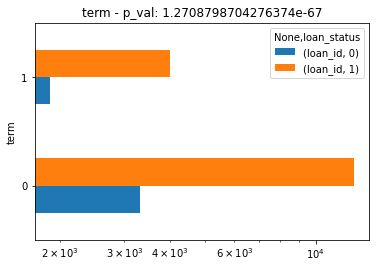

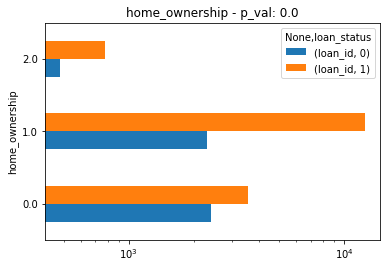

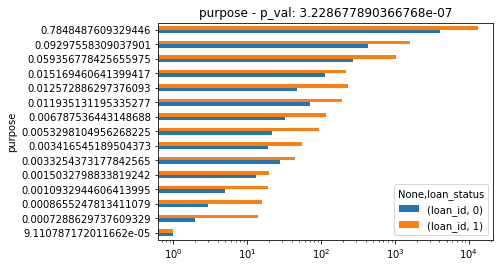

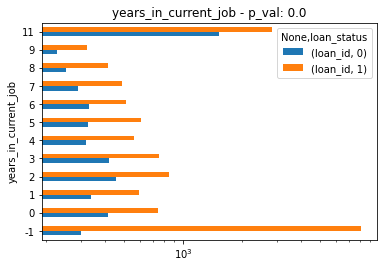

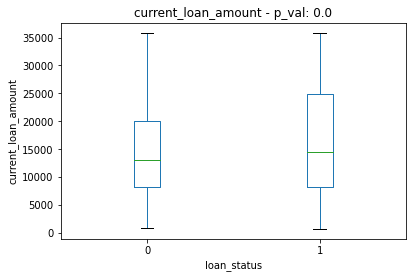

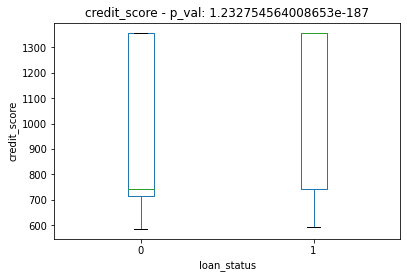

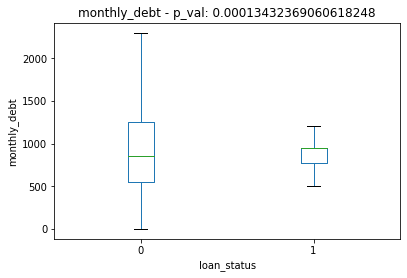

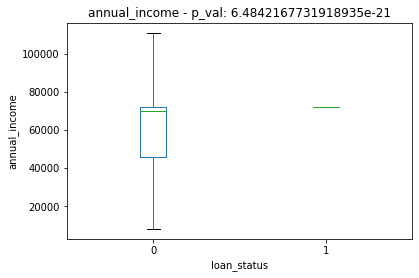

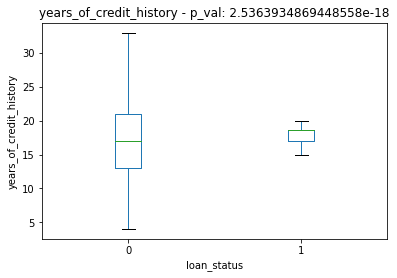

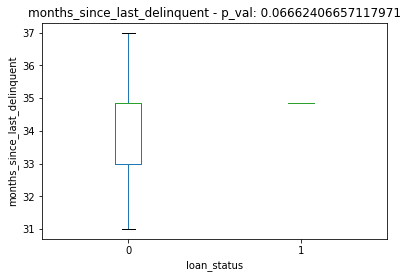

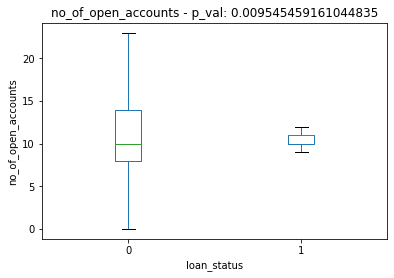

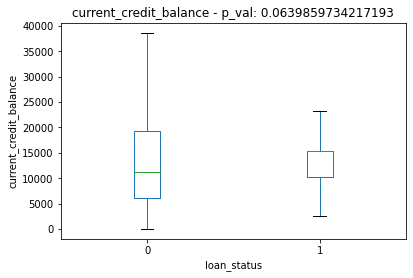

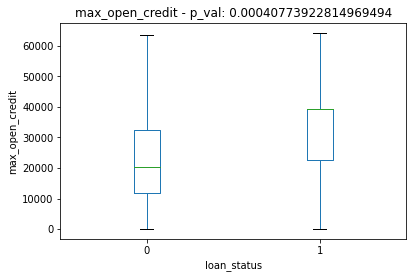

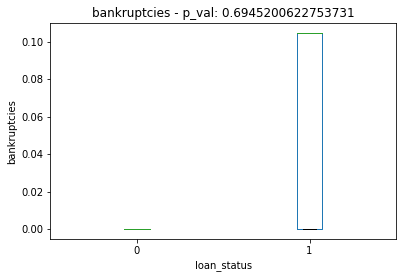

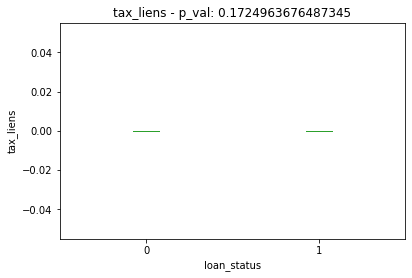

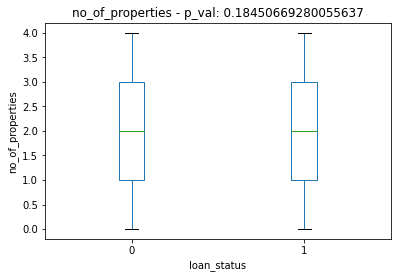

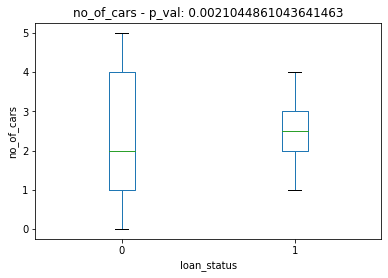

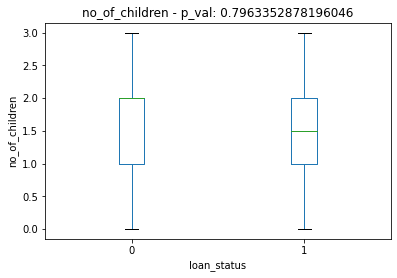

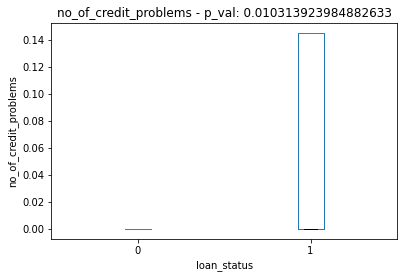

In [9]:
predictors_evaluation = dict()
for col in config.CAT_VARS:
    predictors_evaluation[col] = target_vs_categorical(df, x=col, y='loan_status')

for col in config.NUM_VARS:
    predictors_evaluation[col] = target_vs_numerical(df, x=col, y='loan_status')

In [10]:
pdf = pd.DataFrame(pd.Series(predictors_evaluation), columns=['p_value'])
pdf['reject'] = pdf['p_value'] > 0.05
pdf.sort_values('p_value', ascending=False)

,p_value,reject
no_of_children,7.963353e-01,True
bankruptcies,6.945201e-01,True
no_of_properties,1.845067e-01,True
tax_liens,1.724964e-01,True
months_since_last_delinquent,6.662407e-02,True
current_credit_balance,6.398597e-02,True
no_of_credit_problems,1.031392e-02,False
no_of_open_accounts,9.545459e-03,False
no_of_cars,2.104486e-03,False
max_open_credit,4.077392e-04,False
